In [22]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

In [23]:
import math
import os

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.providers.fake_provider import FakeManilaV2, FakeBelemV2
from qiskit import transpile
from qiskit.tools.visualization import plot_histogram
import time
from multiprocessing import Pool
pi = math.pi
backend = FakeManilaV2()
# backend = FakeBelemV2()

backends = ['fakemanilaV2', 'fakebelemV2']
methods = ['sabre', 'stochastic', 'none']

In [24]:
# Importing standard Qiskit libraries and configuring account
from qiskit import *
from qiskit import IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import style
style.use('bmh')

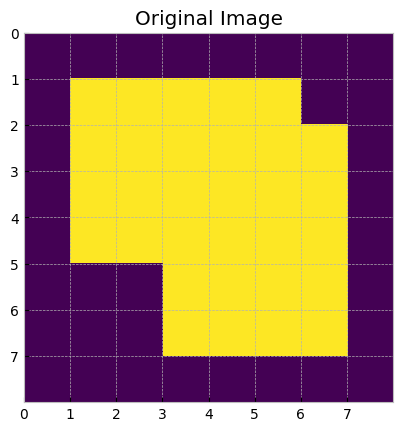

In [25]:
# A 8x8 binary image represented as a numpy array
image = np.array([ [0, 0, 0, 0, 0, 0, 0, 0],
                  [0, 1, 1, 1, 1, 1, 0, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 1, 1, 1, 1, 1, 1, 0],
                  [0, 0, 0, 1, 1, 1, 1, 0],
                  [0, 0, 0, 1, 1, 1, 1, 0],
                  [0, 0, 0, 0, 0, 0, 0, 0] ])

# Function for plotting the image using matplotlib
def plot_image(img, title: str):
    plt.title(title)
    plt.xticks(range(img.shape[0]))
    plt.yticks(range(img.shape[1]))
    plt.imshow(img, extent=[0, img.shape[0], img.shape[1], 0], cmap='viridis')
    plt.show()
    
plot_image(image, 'Original Image')

In [26]:
# Convert the raw pixel values to probability amplitudes
def amplitude_encode(img_data):
    
    # Calculate the RMS value
    rms = np.sqrt(np.sum(np.sum(img_data**2, axis=1)))
    
    # Create normalized image
    image_norm = []
    for arr in img_data:
        for ele in arr:
            image_norm.append(ele / rms)
        
    # Return the normalized image as a numpy array
    return np.array(image_norm)

# Get the amplitude ancoded pixel values
# Horizontal: Original image
image_norm_h = amplitude_encode(image)

# Vertical: Transpose of Original image
image_norm_v = amplitude_encode(image.T)

In [27]:
# Initialize some global variable for number of qubits
data_qb = 6
anc_qb = 1
total_qb = data_qb + anc_qb

# Initialize the amplitude permutation unitary
D2n_1 = np.roll(np.identity(2**total_qb), 1, axis=1)

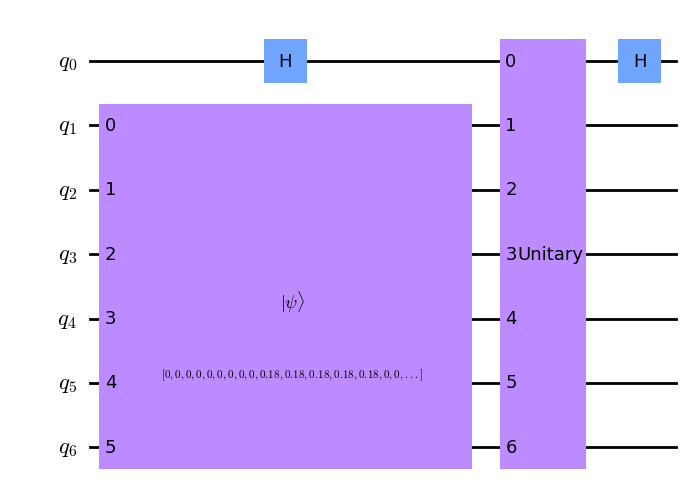

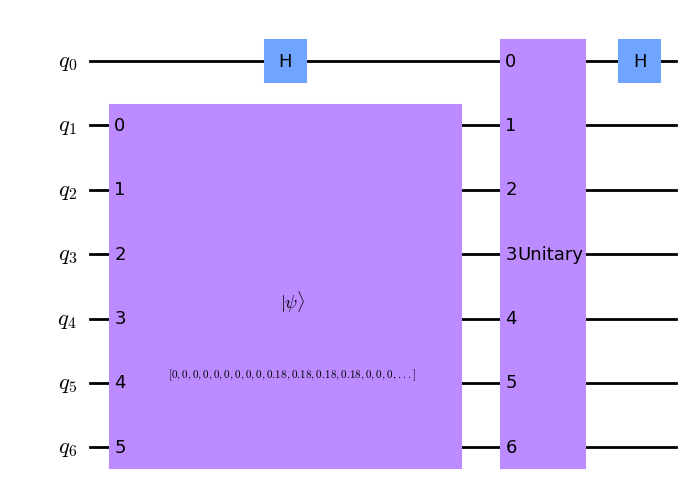

In [28]:
# Create the circuit for horizontal scan
qc_h = QuantumCircuit(total_qb)
qc_h.initialize(image_norm_h, range(1, total_qb))
qc_h.h(0)
qc_h.unitary(D2n_1, range(total_qb))
qc_h.h(0)
display(qc_h.draw('mpl', fold=-1))

# Create the circuit for vertical scan
qc_v = QuantumCircuit(total_qb)
qc_v.initialize(image_norm_v, range(1, total_qb))
qc_v.h(0)
qc_v.unitary(D2n_1, range(total_qb))
qc_v.h(0)
display(qc_v.draw('mpl', fold=-1))

# Combine both circuits into a single list
circ_list = [qc_h, qc_v]

In [29]:
# Simulating the cirucits
back = Aer.get_backend('statevector_simulator')
results = execute(circ_list, backend=back).result()
sv_h = results.get_statevector(qc_h)
sv_v = results.get_statevector(qc_v)

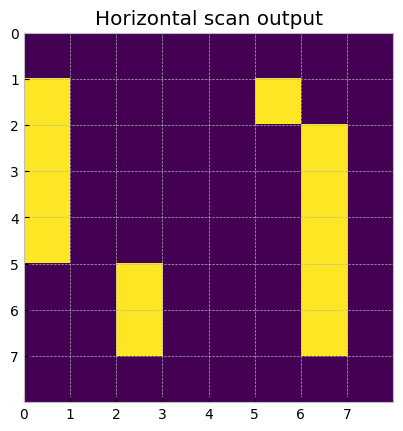

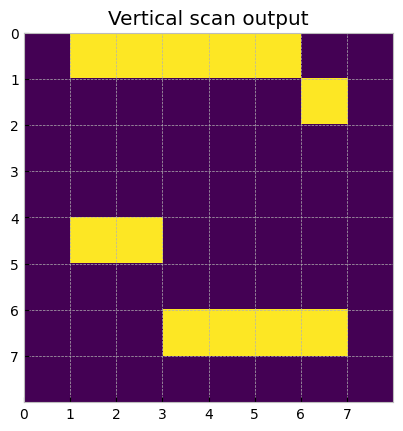

In [30]:
# Classical postprocessing for plotting the output

# Defining a lambda function for
# thresholding to binary values
threshold = lambda amp: (amp > 1e-15 or amp < -1e-15)

# Selecting odd states from the raw statevector and
# reshaping column vector of size 64 to an 8x8 matrix
edge_scan_h = np.abs(np.array([1 if threshold(sv_h[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(8, 8)
edge_scan_v = np.abs(np.array([1 if threshold(sv_v[2*i+1].real) else 0 for i in range(2**data_qb)])).reshape(8, 8).T

# Plotting the Horizontal and vertical scans
plot_image(edge_scan_h, 'Horizontal scan output')
plot_image(edge_scan_v, 'Vertical scan output')

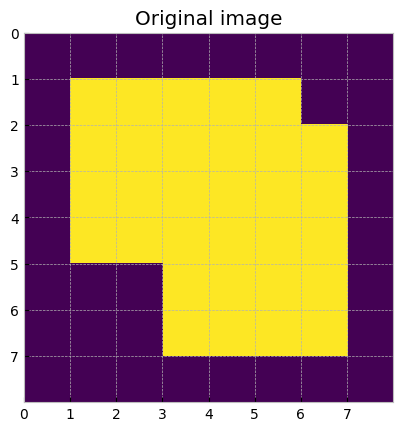

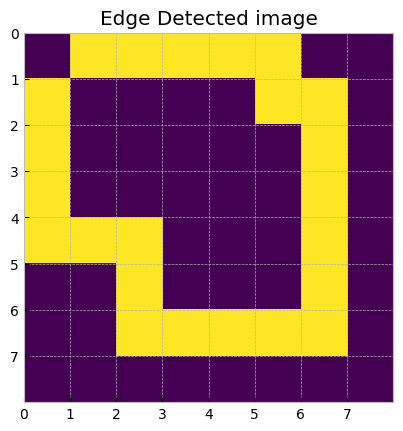

In [31]:
# Combining the horizontal and vertical component of the result
edge_scan_sim = edge_scan_h | edge_scan_v

# Plotting the original and edge-detected images
plot_image(image, 'Original image')
plot_image(edge_scan_sim, 'Edge Detected image')

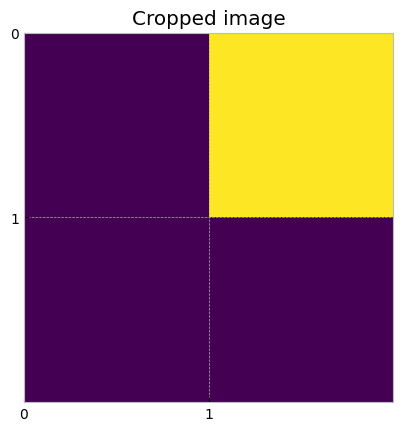

In [32]:
# Create a 2x2 image to be run on the hardware
# The pixels in `image_small` correspond to the pixels at
# (6, 2), (6, 3), (7, 2), (7, 3) respectively
image_small = image[6:8, 2:4]

# Plotting the image_small using matplotlib
plot_image(image_small, 'Cropped image')

In [33]:
# Initialize the number of qubits
data_qb = 2
anc_qb = 1
total_qb = data_qb + anc_qb

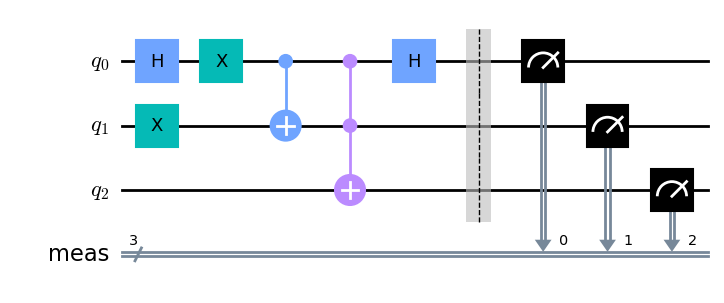

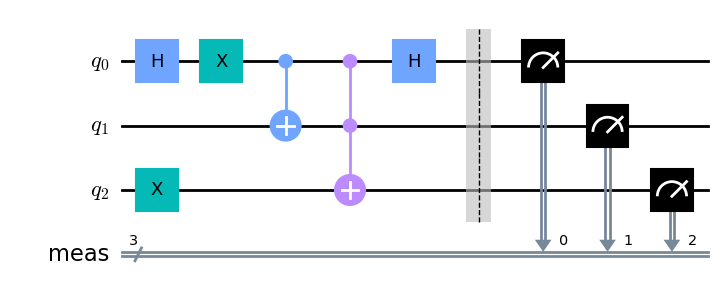

In [34]:
# Create the circuit for horizontal scan
qc_small_h = QuantumCircuit(total_qb)
qc_small_h.x(1)
qc_small_h.h(0)

# Decrement gate - START
qc_small_h.x(0)
qc_small_h.cx(0, 1)
qc_small_h.ccx(0, 1, 2)
# Decrement gate - END

qc_small_h.h(0)
qc_small_h.measure_all()
display(qc_small_h.draw('mpl'))

# Create the circuit for vertical scan
qc_small_v = QuantumCircuit(total_qb)
qc_small_v.x(2)
qc_small_v.h(0)

# Decrement gate - START
qc_small_v.x(0)
qc_small_v.cx(0, 1)
qc_small_v.ccx(0, 1, 2)
# Decrement gate - END

qc_small_v.h(0)
qc_small_v.measure_all()
display(qc_small_v.draw('mpl'))

# Combine both circuits into a single list
circ_list = [qc_small_h, qc_small_v]

In [35]:
# Transpile the circuits for optimized execution on the backend
qc_small_h_t = transpile(qc_small_h, backend=backend, optimization_level=3)
qc_small_v_t = transpile(qc_small_v, backend=backend, optimization_level=3)

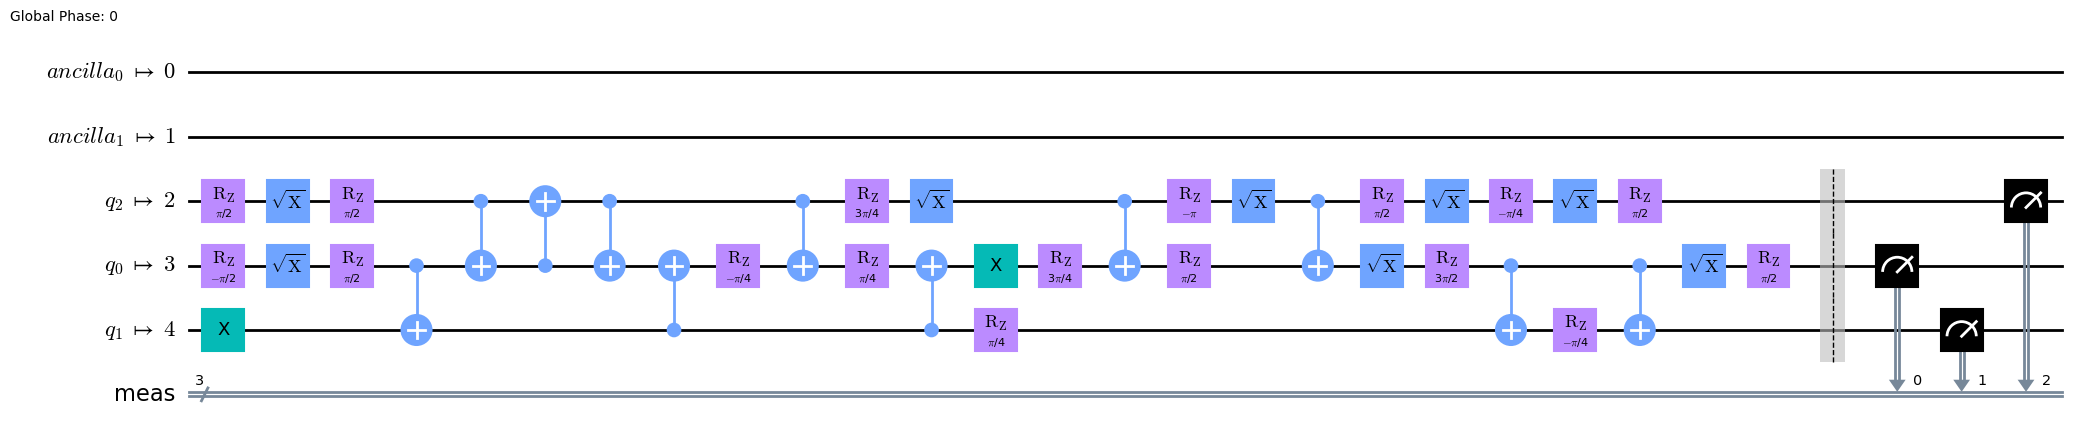

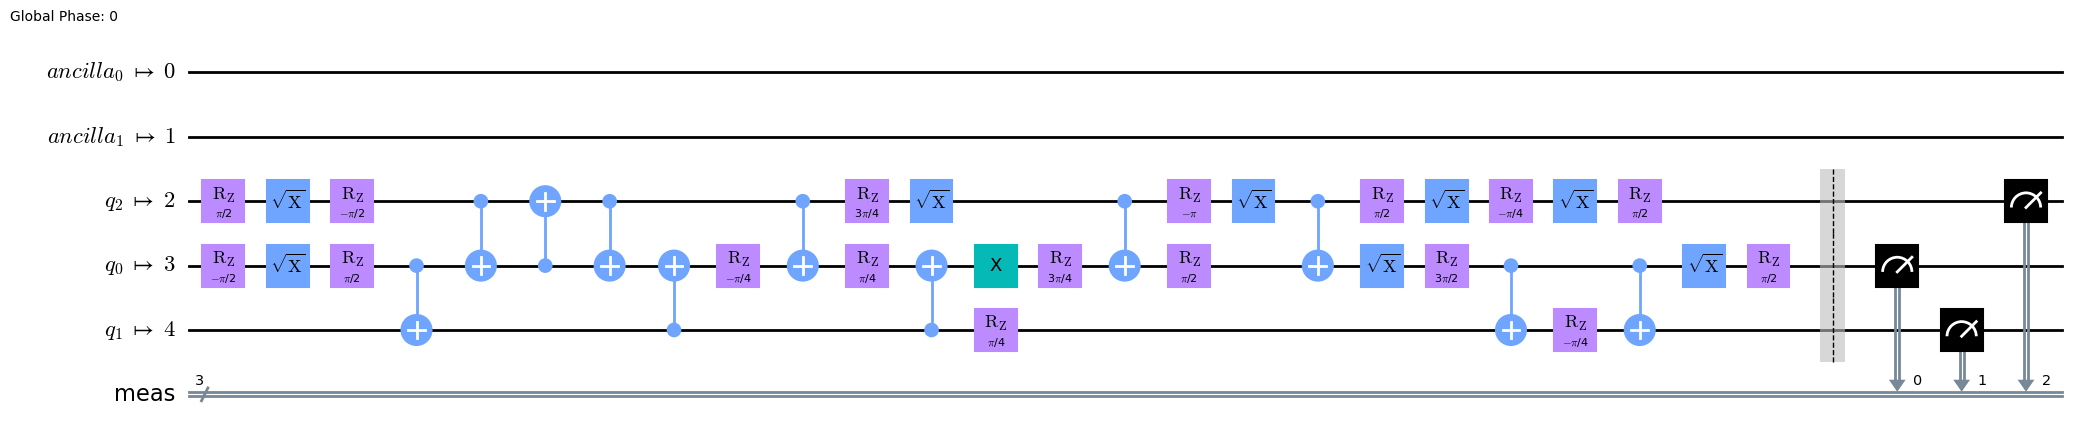

In [36]:
# Combining both circuits into a list
circ_list_t = [qc_small_h_t, qc_small_v_t]

# Drawing the transpiled circuit
display(circ_list_t[0].draw('mpl', fold=-1))
display(circ_list_t[1].draw('mpl', fold=-1))

In [38]:
transpiled_circuit = transpile(qc_small_h_t, backend)
t2 = time.time()
job = backend.run(transpiled_circuit)
counts = job.result().get_counts()
print(time.time() - t2)

0.2963755130767822
